# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **20 de septiembre** y se realizará a través de Bloque Neón.

In [277]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
%matplotlib inline

In [278]:
heart_df=pd.read_csv("heartDisease/framingham.csv")
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [279]:
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

<AxesSubplot:ylabel='TenYearCHD'>

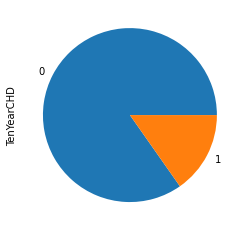

In [280]:
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [281]:
x = heart_df.iloc[:,:-1]
y = heart_df.iloc[:,-1]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=22)

In [282]:
scaler = MinMaxScaler() # Utilice un MinMaxScaler #
x_train = scaler.fit_transform(x_train) # Ajuste y Aplique el Escalamiento (función fit_transform) #
x_test = scaler.transform(x_test) # Aplique el Escalamiento (función transform) #

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [283]:
logreg = LogisticRegression()  # Modelo de Regresión Logística #
logreg.fit(x_train, y_train)  # Entrenamiento sobre los Datos #
y_pred = logreg.predict(x_test)  # Predicción de Etiquetas #

print(f'Precisión inicial: {logreg.score(x_test, y_test)}') # CÁLCULO DE LA PRECISIÓN DEL MODELO (score de LogisticRegression llama a accuracy_score) #

Precisión inicial: 0.844


### Conclusión
El "accuracy" del modelo de 0.844 indica que de todos los datos se prueba, se logró clasificar adecuadamente un 84.4%, es decir que el modelo se equivocará solo en un 15.6% de los casos. Esto quiere decir que podrá predecir correctamente para la mayoría de pacientes si estos tienen un riesgo de padecer enfermedad coronaria en los siguientes 10 años. Aparentemente no está nada mal para ser el primer modelo. Sin embargo, esta información es limitada puesto que no se sabe realmente en qué casos se equivoca más. Además, al leer este resultado se incurre en un sesgo al no tener en cuenta el gran desbalance en los datos. Podría ser perfectamente que todos los pacientes se estén clasificando sin riesgo y que este 84% simplemente corresponda a los que naturalmente no corren ningún riesgo. Esto no aportaría ninguna información valiosa a pesar de tener un "accuracy" alto. Es importante entrar evaluar con mayor detalle el modelo o corregir el desbalance de las clases.

### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.

Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

<AxesSubplot:>

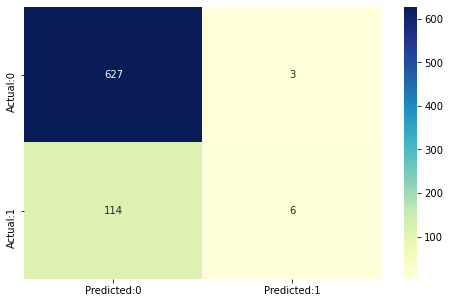

In [284]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [285]:
from sklearn.preprocessing import binarize

umbrales = np.arange(0.1, 1, 0.1) # Vector que Contiene los Umbrales a Analizar #

for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test) # Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    y_pred2 = binarize(y_pred_prob_yes, threshold = umbral)[:,1] # Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    cm2 = confusion_matrix(y_test,y_pred2)
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos positivos.
Sensitividad: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n''')


->Para un umbral de 0.1 tenemos esta matriz de confusión:
[[306 324]
 [ 18 102]]
Con 408 predicciones correctas y 18 falsos positivos.
Sensitividad: 0.85 Especificidad: 0.4857

->Para un umbral de 0.2 tenemos esta matriz de confusión:
[[512 118]
 [ 63  57]]
Con 569 predicciones correctas y 63 falsos positivos.
Sensitividad: 0.475 Especificidad: 0.8127

->Para un umbral de 0.3 tenemos esta matriz de confusión:
[[583  47]
 [ 94  26]]
Con 609 predicciones correctas y 94 falsos positivos.
Sensitividad: 0.2167 Especificidad: 0.9254

->Para un umbral de 0.4 tenemos esta matriz de confusión:
[[612  18]
 [104  16]]
Con 628 predicciones correctas y 104 falsos positivos.
Sensitividad: 0.1333 Especificidad: 0.9714

->Para un umbral de 0.5 tenemos esta matriz de confusión:
[[627   3]
 [114   6]]
Con 633 predicciones correctas y 114 falsos positivos.
Sensitividad: 0.05 Especificidad: 0.9952

->Para un umbral de 0.6 tenemos esta matriz de confusión:
[[629   1]
 [119   1]]
Con 630 predicciones correc

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

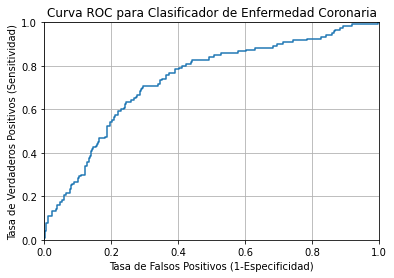

In [286]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

### Conclusiones
Realmente en el caso en el que se quiere predecir si un paciente puede estar en riesgo de sufrir una enfermedad complicada en sus siguientes 10 años se considera que sea preferible equivocarse alertando a un paciente sano sobre un posible riesgo que dejar de alertar a un paciente que puede estar en riesgo. Es decir, en este caso es preferible un falso positivo que un falso negativo. Por lo tanto, se prioriza el deseo de disminuir el error tipo II. La métrica asociada a este error es la sensitividad. Lo primero que se puede observar de la curva ROC es que dada su forma o concavidad se puede deducir que el área debajo de la curva es superior a 0.5. Esto implica que el modelo tiene una medida de separabilidad favorable. En segundo lugar, se debe tener en cuenta de al desear mejorar la sensitividad, podría llegar a ser favorable la disminución del umbral para hacer que más pacientes se clasifiquen como positivos para riesgo de enfermedad coronaria. No obstante, se debe tener cuidado en caer en cualquiera de los extremos. Una sensibilidad que podría ser deseada podría variar entre 0.6 y 0.8 de forma que se obtengan también medidas aceptables de especificidad entre el 0.6 y 0.8. Para lograr esto, según las pruebas realizadas, se podría encontrar un umbral entre 0.1 y 0.2 que haga que se cumpla la sugerencia. Este sería un tratamiento de datos balanceados adecuado.

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [287]:
# seed = np.random.randint(100000) # Pruebas #
seed = 1961 # Elegido #
print(f'seed: {seed}')
np.random.seed(seed)
X_train_array = np.c_[np.ones(x_train.shape[0]), x_train]
y_train_array = y_train.values

# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-5

def sigma(w, x):
    # Salida de la función sigmoide #
    res_sigmoid = 1 / (1 + np.exp(-np.dot(w, x)))
    return res_sigmoid

tasas = [10, 1, 0.1, 0.01, 0.001, 0.0001] # Defina un vector que contenga las tasas que desea probar - ultimo es mejor modelo#
# tasas = [1]  # Defina un vector que contenga las tasas que desea probar #

mejor_modelo_w = np.zeros(X_train_array.shape[1])
sensitividad_max = 0

for tasa in tasas:
    w0 = np.random.rand(X_train_array.shape[1])  # Inicialización de w #
    w = w0.copy()
    # print(f'w0 tasa {tasa}: {w}')

    error = float('inf')
    dif = float('inf')
    iteraciones = 0

    while np.abs(error)>eps and iteraciones < 5000:         # Criterio de parada 1 #
    # for j in range (0, 1000):  # Criterio de parada 2 #
    # while np.abs(dif) > eps and iteraciones < 5000:         # Criterio de parada 3 #
        # # Desarrollo de algoritmo # #
        # Posición aleatoria #
        i = np.random.randint(0, X_train_array.shape[0] - 1)
        xActual = X_train_array[i]
        yActual = y_train_array[i]
        # print(f'random{iteraciones} es {i}')

        g = sigma(w, xActual)
        error = yActual - g

        # print(f'x{iteraciones}: {xActual}, g: {g}, error: {error}')

        w_ant = w
        w = w + tasa * error * xActual

        dif = np.linalg.norm(w - w_ant)
        iteraciones += 1

        # # # # # # # # # # # # # # # #

    # print(f'w{iteraciones} error {error} tasa {tasa}: {w}')
    X_test_array = np.c_[np.ones(x_test.shape[0]), x_test]
    y_test_array = y_test.values

    y_pred = np.zeros(len(x_test))

    for k in range(0, len(x_test)):
        prob = sigma(w, X_test_array[k])
        if prob > 0.5:
            y_pred[k] = 1
        else:
            y_pred[k] = 0

    precision = sklearn.metrics.accuracy_score(y_test,y_pred)
    print(
        f'Precisión modelo tasa {tasa}: {precision}')
    cm_temp = confusion_matrix(y_test, y_pred)
    conf_matrix_temp = pd.DataFrame(
        data=cm_temp, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])

    sensitividad = round(cm_temp[1,1]/(float(cm_temp[1,1]+cm_temp[1,0])), 4)
    if sensitividad > sensitividad_max and precision > 0.5: 
        mejor_modelo_w = w
        sensitividad_max = sensitividad

    print(f'''Con {cm_temp[0,0]+cm_temp[1,1]} predicciones correctas y {cm_temp[1,0]} falsos negativos.
Sensitividad: {sensitividad} Especificidad: {round(cm_temp[0,0]/(float(cm_temp[0,0]+cm_temp[0,1])), 4)}\n''')


seed: 1961
Precisión modelo tasa 10: 0.84
Con 630 predicciones correctas y 120 falsos negativos.
Sensitividad: 0.0 Especificidad: 1.0

Precisión modelo tasa 1: 0.5186666666666667
Con 389 predicciones correctas y 29 falsos negativos.
Sensitividad: 0.7583 Especificidad: 0.473

Precisión modelo tasa 0.1: 0.8413333333333334
Con 631 predicciones correctas y 117 falsos negativos.
Sensitividad: 0.025 Especificidad: 0.9968

Precisión modelo tasa 0.01: 0.8413333333333334
Con 631 predicciones correctas y 117 falsos negativos.
Sensitividad: 0.025 Especificidad: 0.9968

Precisión modelo tasa 0.001: 0.84
Con 630 predicciones correctas y 120 falsos negativos.
Sensitividad: 0.0 Especificidad: 1.0

Precisión modelo tasa 0.0001: 0.16
Con 120 predicciones correctas y 0 falsos negativos.
Sensitividad: 1.0 Especificidad: 0.0



### Análisis

Se hicieron muchas pruebas variando distintos hiperparámetros tales como la tasa y los criterios de parada, e incluso la aleatoriedad de los datos. En estas pruebas se encontró como tendencia general que con tasas muy altas se encontraba la mayor "accuracy" y a tasas muy bajas lo contrario. Sin embargo, no era fiable guiarse únicamente por este parámetro. Por lo tanto, se entró a revisar las matrices de confusión asociadas y se encontró que con las tasas muy altas simplemente el modelo predecía la clase positiva (que de hecho es la minoritaria) en todos los casos. Debido al desbalance, esto causa un "accuracy" alto a pesar de que sea un modelo muy "dummy". En el extremo contrario, disminuir mucho la tasa causa todo lo contrario, la sensitividad aumentaba a 1 y el "accuracy" a 0.16 dado que el modelo solo predecía la clase negativa. Aunque es deseable aumentar la sensitividad como se mencionó anteriormente, no se debe incurrir en seleccionar un modelo "dummy" ni se debe castigar tanto las demás métricas. Dado el análisis hecho con la curva ROC se seleccionó un modelo con una sensitividad de 0.7583 y un "accuracy" de 0.5187. Esto se logró con una tasa de 1. También se intentó modificar el umbral una vez se fijó la tasa pero se encontró que rápidamente se salía de la zona en la que el trade off es aceptable. Por lo tanto, en este caso se mantuvo en 0.5 aunque cabe resaltar que vale la pena jugar con ambos hiperparámetros (tasa y threshold).

## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

In [290]:
# MEJOR MODELO #
X_test_array = np.c_[np.ones(x_test.shape[0]), x_test]
y_test_array = y_test.values
y_pred = np.zeros(len(x_test))

for k in range(0, len(x_test)):
        prob = sigma(mejor_modelo_w, X_test_array[k])
        if prob > 0.5:
            y_pred[k] = 1
        else:
            y_pred[k] = 0


Con 389 predicciones correctas y 29 falsos negativos.
Sensitividad: 0.7583 Especificidad: 0.473

Ponderando tanto sensitividad como precisión, el score F es 0.33513525785905074



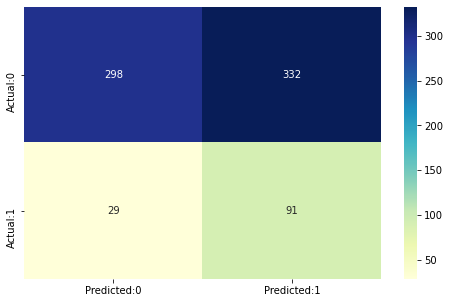

In [293]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

sensitivity = round(cm[1,1]/(float(cm[1,1]+cm[1,0])), 4)
prec = round(cm[1,1]/(float(cm[1,1]+cm[0,1])), 4)

print(f'''Con {cm[0,0]+cm[1,1]} predicciones correctas y {cm[1,0]} falsos negativos.
Sensitividad: {sensitivity} Especificidad: {round(cm[0,0]/(float(cm[0,0]+cm[0,1])), 4)}\n''')
print(f'''Ponderando tanto sensitividad como precisión, el score F es {(2*sensitivity*prec)/(sensitivity+prec)}\n''')

### Análisis

Como se mencionó anteriormente, el modelo fue seleccionado de una vez teniendo en cuenta la matriz de confusión. Particularmente se puede deducir que este modelo deja pasar una cantidad relativamente baja (en comparación con otros modelos) de pacientes con riesgo de padecer enfermedad coronaria sin alertarlos pero alerta a un montón de otros pacientes que realmente no tienen ningún riesgo. No necesariamente es un buen modelo, de hecho ponderando ambos sensitividad y precisión se halla un F-score de 0.33, lo cual no parece ser muy alto. En realidad si se fuese a implementar en la vida real, se sugeriría entender mejor el problema para poder tomar mejores decisiones teniendo en cuenta las implicaciones que pueden tener los errores tipo I y tipo II para los pacientes. En segundo lugar, se podría "jugar" un poco más con los hiperparámetros, sacar más modelos y hacer uso del F-score para evaluarlos además de las demás métricas. Finalmente, lo mejor sería experimentar con un oversampling de la clase minoritaria pues puede ser una técnica más robusta para lidiar con la clase desbalanceada.